# River Discharge

In [14]:
from __future__ import annotations

import pandas as pd
import xarray as xr

import pydaymet as daymet
import pygeohydro as gh
from pygeohydro import NWIS, plot

import dataretrieval.nwis as nwis_usgs


import folium
import matplotlib.pyplot as plt

_ = xr.set_options(display_expand_attrs=False)

We can explore the available NWIS stations within a bounding box using ``interactive_map`` function. It returns an interactive map and by clicking on an station some of the most important properties of stations are shown so you can decide which station(s) to choose from.

In [3]:
bbox = (-111.6, 40.5, -110.7, 41.3) # bbox around summit county, utah

In [4]:

# 1. Get the site info 
nwis = NWIS()
query = {"bBox": ",".join(map(str, bbox)), "hasDataTypeCd": "dv", "parameterCd": "00060"}
sites = nwis.get_info(query, expanded=False)

# NatGeo Tiles URL and Attribution
natgeo_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
natgeo_attr = 'Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC'

# 2. Initialize a map at the center of your bbox
m = folium.Map(location=[(bbox[1] + bbox[3])/2, 
                         (bbox[0] + bbox[2])/2],
               zoom_start=9,
               tiles=natgeo_url,
                attr=natgeo_attr
    )

# 3. Add the sites to the map
for _, row in sites.iterrows():
    folium.Marker(
        location=[row.dec_lat_va, row.dec_long_va],
        popup=f"Site: {row.site_no}<br>Name: {row.station_nm}",
        tooltip=row.site_no
    ).add_to(m)

m

We can get more information about these stations using the `get_info` function from `NWIS` class.

In [5]:
nwis = NWIS()
query = {
    "bBox": ",".join(f"{b:.06f}" for b in bbox),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info_box = nwis.get_info(query)

print(f'PyGeoHydro found {len(set(info_box.site_no))} unique gages in this region.')

PyGeoHydro found 84 unique gages in this region.


Now, let's select all the stations that their daily mean streamflow data are available between 2000-01-01 and 2010-12-31.

In [6]:
# Specify date range of interest
dates = ("2020-01-01", "2020-12-31") 

# Filter stations to have only those with proper dates
stations = info_box[
    (info_box.begin_date <= dates[0]) & (info_box.end_date >= dates[1])
    ].site_no.tolist()

# Remove duplicates by converting to a set
stations = list(set(stations))

print(f'Great, the NWIS found {len(stations)} stations which have data between {dates[0]} and {dates[1]}.')

Great, the NWIS found 19 stations which have data between 2020-01-01 and 2020-12-31.


One of the useful information in the database in Hydro-Climatic Data Network - 2009 (HCDN-2009) flag. This flag shows whether the station is natural (True) or affected by human activities (False). If an station is not available in the HCDN dataset `None` is returned.

In [7]:
query = {
    "site": ",".join(stations),
    "hasDataTypeCd": "dv",
    "outputDataTypeCd": "dv",
}
info = nwis.get_info(query, expanded=True)

info = info.drop_duplicates(subset=['site_no'])
info.set_index("site_no").hcdn_2009

site_no
10011500    False
10016900    False
10128500    False
10129300    False
10129500    False
10129900    False
10130500    False
10131000    False
10132000    False
10132500    False
10133000    False
10133600    False
10133650    False
10133800    False
10133980    False
10137300    False
10154200    False
10155000    False
10155200    False
Name: hcdn_2009, dtype: bool

We can get the daily mean streamflow for these stations using the ``get_streamflow`` function. This function defaults flow to `cms`, but `mmd` is often useful for hydrolgy models and plotting hydrologic signatures.

In [8]:
# Retrieve the flow data
flow_data = nwis.get_streamflow(stations, dates, mmd=False) # Get data in cubic meters per second, the mmd flag does not work

# Remove gages with nans
flow_data = flow_data.dropna(axis = 1, how = 'any')

flow_data.head()

/scratch/local/u1154915/794767/ipykernel_2638367/463988840.py:2: UserWarning: Dropped 2 stations since they don't have discharge data from 2020-01-01 to 2020-12-31.
  flow_data = nwis.get_streamflow(stations, dates, mmd=False) # Get data in cubic meters per second, the mmd flag does not work


,USGS-10011500,USGS-10016900,USGS-10128500,USGS-10129300,USGS-10129500,USGS-10129900,USGS-10130500,USGS-10131000,USGS-10132000,USGS-10132500,USGS-10133600,USGS-10133650,USGS-10133800,USGS-10133980,USGS-10154200,USGS-10155000,USGS-10155200
2020-01-01 07:00:00+00:00,1.186476,1.597070,1.710338,1.585743,0.804198,0.199917,1.175149,0.569169,0.027751,0.262780,0.242392,0.190006,0.461565,0.659783,1.237446,1.953862,3.426338
2020-01-02 07:00:00+00:00,1.200634,1.534773,1.716001,1.662199,0.841010,0.193687,1.180813,0.574832,0.027751,0.262780,0.253436,0.204731,0.481386,0.702258,1.228951,1.979348,3.398022
2020-01-03 07:00:00+00:00,1.209129,1.554595,1.710338,1.659367,0.821189,0.194537,1.152496,0.574832,0.027751,0.262780,0.253153,0.217190,0.492713,0.719248,1.211961,2.027486,3.398022
2020-01-04 07:00:00+00:00,1.194971,1.594238,1.693347,1.659367,0.798535,0.188590,1.073208,0.489881,0.028034,0.262780,0.263630,0.221438,0.509703,0.617307,1.180813,2.078457,3.398022
2020-01-05 07:00:00+00:00,1.177981,1.585743,1.676357,1.645209,0.775882,0.181228,1.093030,0.478555,0.028034,0.263064,0.257683,0.232764,0.495545,0.555010,1.149664,2.137922,3.398022


In [24]:
# 1. Fetch expanded info for your stations
# This includes 'drain_area_va' (in square miles)
df_info, metadata = nwis_usgs.get_info(sites=stations)

# 2. Create a mapping dictionary for easy lookup
# We'll convert Sq Miles to Sq Km immediately (1 sq mi = 2.58999 sq km), as cms is used in HyRiver
area_map = (df_info.set_index('site_no')['drain_area_va'] * 2.58999).to_dict()

print(f"Successfully retrieved areas for {len(area_map)} stations.")
df_info.head()

Successfully retrieved areas for 19 stations.


,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,10011500,BEAR RIVER NEAR UTAH-WYOMING STATE LINE,ST,405755.0,1105110.0,40.965208,-110.853539,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,465600100.0,POINT (-110.85354 40.96521)
1,USGS,10016900,"BEAR RIVER AT EVANSTON, WY",ST,411611.5,1105749.3,41.269861,-110.963694,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,465600100.0,POINT (-110.96369 41.26986)
2,USGS,10128500,"WEBER RIVER NEAR OAKLEY, UT",ST,404414.0,1111450.0,40.737172,-111.247965,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,474900100.0,POINT (-111.24797 40.73717)
3,USGS,10129300,"WEBER RIVER NEAR PEOA, UTAH",ST,404504.0,1112211.0,40.751060,-111.370472,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-111.37047 40.75106)
4,USGS,10129500,"WEBER RIVER NEAR WANSHIP, UT",ST,404734.0,1112415.0,40.792726,-111.404918,M,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,464900100.0,POINT (-111.40492 40.79273)


In [10]:
flow_mmd = flow_data.copy()

for site in flow_mmd.columns:
    site_id =site.strip('USGS-')
    # Get the area for this specific station from your cleaned info_box    
    area = df_info.loc[df_info.site_no == site_id, 'drain_area_va'].iloc[0]
    
    if area > 0:
        flow_mmd[site] = (flow_mmd[site] * 2.446575) / area
    else:
        print(f"Warning: Station {site} has no drainage area listed.")

flow_mmd.head()        

,USGS-10011500,USGS-10016900,USGS-10128500,USGS-10129300,USGS-10129500,USGS-10129900,USGS-10130500,USGS-10131000,USGS-10132000,USGS-10132500,USGS-10133600,USGS-10133650,USGS-10133800,USGS-10133980,USGS-10154200,USGS-10155000,USGS-10155200
2020-01-01 07:00:00+00:00,0.016877,0.008860,0.025830,0.013107,0.005873,0.028110,0.006609,0.005570,0.000093,0.005227,0.067543,0.011042,0.019742,0.014675,0.018688,0.020784,0.031047
2020-01-02 07:00:00+00:00,0.017078,0.008515,0.025916,0.013739,0.006142,0.027234,0.006641,0.005625,0.000093,0.005227,0.070621,0.011898,0.020590,0.015619,0.018560,0.021055,0.030791
2020-01-03 07:00:00+00:00,0.017199,0.008625,0.025830,0.013715,0.005997,0.027353,0.006482,0.005625,0.000093,0.005227,0.070542,0.012622,0.021074,0.015997,0.018303,0.021567,0.030791
2020-01-04 07:00:00+00:00,0.016998,0.008844,0.025573,0.013715,0.005832,0.026517,0.006036,0.004794,0.000094,0.005227,0.073461,0.012869,0.021801,0.013730,0.017833,0.022109,0.030791
2020-01-05 07:00:00+00:00,0.016756,0.008797,0.025317,0.013598,0.005666,0.025482,0.006148,0.004683,0.000094,0.005233,0.071804,0.013527,0.021196,0.012344,0.017363,0.022742,0.030791


By default, `get_streamflow` returns a `pandas.DataFrame` that has an `attrs` method containing metadata for all the stations.

Moreover, we can get the same data as `xarray.Dataset` as follows:

In [11]:
flow_ds = nwis.get_streamflow(stations, dates, mmd=False, to_xarray=True)
flow_ds

/scratch/local/u1154915/794767/ipykernel_2638367/4294091074.py:1: UserWarning: Dropped 2 stations since they don't have discharge data from 2020-01-01 to 2020-12-31.
  flow_ds = nwis.get_streamflow(stations, dates, mmd=False, to_xarray=True)


<xarray.Dataset> Size: 59kB
Dimensions:       (time: 366, station_id: 17)
Coordinates:
  * time          (time) datetime64[ns] 3kB 2020-01-01T07:00:00 ... 2020-12-3...
  * station_id    (station_id) object 136B 'USGS-10011500' ... 'USGS-10155200'
Data variables:
    discharge     (time, station_id) float64 50kB 1.186 1.597 ... 1.501 3.426
    station_nm    (station_id) <U49 3kB 'Bear River Near Utah-Wyoming State, ...
    dec_lat_va    (station_id) float64 136B 40.97 41.27 40.74 ... 40.61 40.55
    dec_long_va   (station_id) float64 136B -110.9 -111.0 ... -111.3 -111.4
    alt_va        (station_id) float64 136B 7.961e+03 6.73e+03 ... 5.692e+03
    alt_acy_va    (station_id) float64 136B 0.14 10.0 0.14 ... 0.22 0.1 0.09
    alt_datum_cd  (station_id) <U6 408B 'NAVD88' 'NGVD29' ... 'NAVD88' 'NAVD88'
    huc_cd        (station_id) <U8 544B '16010101' '16010101' ... '16020203'
    begin_date    (station_id) <U10 680B '1942-07-01' ... '2001-09-08'
    end_date      (station_id) <U10 680B '2026-01-27' ... '2026-01-27'
Attributes: (1)

Then we can use the ``signatures`` function to plot hydrologic signatures of the streamflow. Note that the input time series should be in mm/day. This function has argument, `output`, for saving the plot as a `png` file.

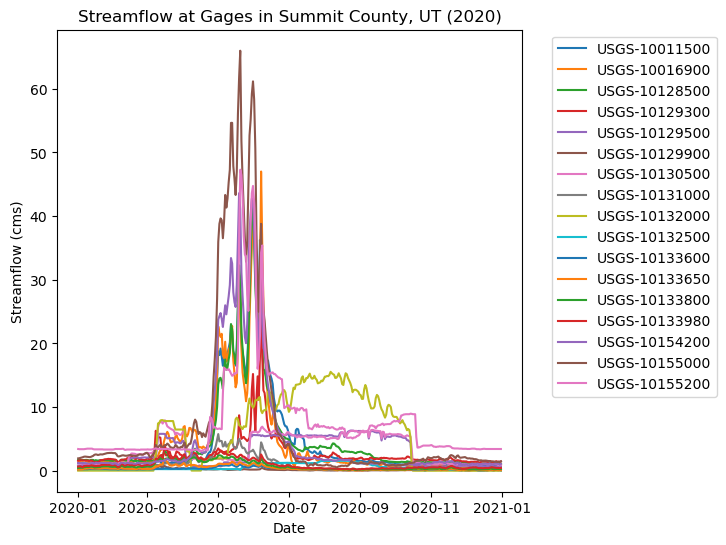

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Streamflow at Gages in Summit County, UT (2020)")
ax.set_ylabel("Streamflow (cms)")
ax.set_xlabel("Date")

# Plot and suppress output
ax.plot(flow_data.index, flow_data.values)

# Add legend outside the plot so it doesn't cover the data
ax.legend(flow_data.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This function also can show precipitation data as a bar plot. Let's use [PyDaymet](https://github.com/cheginit/pydaymet) to get the precipitation at the NWIS stations location.

In [34]:
#this gets instantaneous data for a single site
sid = "10011500"
singlesite = nwis.get_streamflow(sid, dates, freq="dv") #other options are "iv" for instantaneous, "dv" for daily values, 'uv' for unit values
singlesite.index = pd.to_datetime(singlesite.index.strftime("%Y-%m-%d"))

singlesite.head()

,USGS-10011500
2020-01-01,1.186476
2020-01-02,1.200634
2020-01-03,1.209129
2020-01-04,1.194971
2020-01-05,1.177981


In [39]:
singlesite.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

In [41]:

coords = tuple(df_info[df_info.site_no == sid][["dec_long_va", "dec_lat_va"]].to_numpy()[0])
prcp = daymet.get_bycoords(coords, dates, variables="prcp")
#slice the index to match singlesite
prcp = prcp.loc[dates[0]:dates[1]]
prcp.head()

,prcp (mm/day)
time,
2020-01-01,6.28
2020-01-02,0.00
2020-01-03,0.00
2020-01-04,0.00
2020-01-05,0.00


In [42]:
#join the two dataframes
combined = pd.concat([singlesite, prcp], axis=1)
combined.columns = ['streamflow_cms', 'prcp_mmday']
combined.head()

,streamflow_cms,prcp_mmday
2020-01-01,1.186476,6.28
2020-01-02,1.200634,0.00
2020-01-03,1.209129,0.00
2020-01-04,1.194971,0.00
2020-01-05,1.177981,0.00


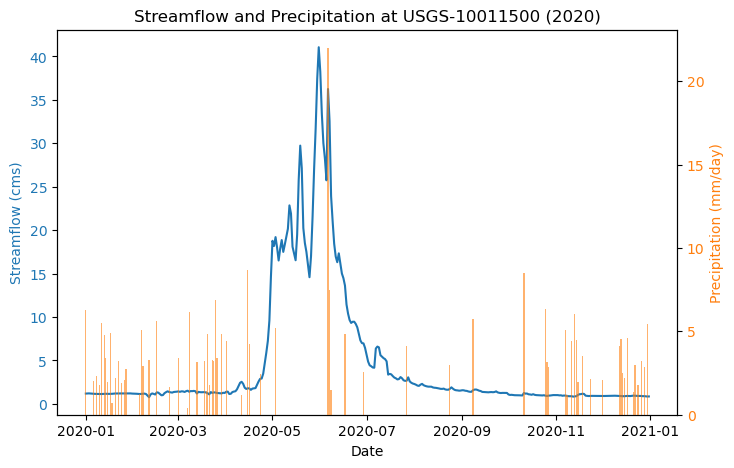

In [43]:
#plotting the combined data
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_title(f"Streamflow and Precipitation at USGS-{sid} (2020)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Streamflow (cms)", color='tab:blue')
ax1.plot(combined.index, combined['streamflow_cms'], color='tab:blue', label='Streamflow (cms)')
ax1.tick_params(axis='y', labelcolor='tab:blue')    
#add second y axis
ax2 = ax1.twinx()
ax2.set_ylabel("Precipitation (mm/day)", color='tab:orange')
ax2.bar(combined.index, combined['prcp_mmday'], color='tab:orange', alpha=0.6, label='Precipitation (mm/day)')
ax2.tick_params(axis='y', labelcolor='tab:orange')